In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import d2l

In [2]:
import utils

#### 1. 准备数据

In [3]:
train_data = pd.read_csv(utils.download('kaggle_house_train'))
test_data = pd.read_csv(utils.download('kaggle_house_test'))

In [4]:
train_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


#### 2. 数据预处理

In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))  # 去掉ID列

In [6]:
all_features.shape

(2919, 79)

In [7]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # 数字类型的列

In [9]:
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))  # 数据预处理，标准化数据 

In [10]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal


In [11]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)  # 用0填充缺失值

In [12]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal


In [13]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [14]:
all_features.shape

(2919, 330)

In [15]:
all_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,False,True,False,False,False,False,False,True,False,False
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,False,True,False,False,False,False,False,True,False,False
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,False,True,False,False,False,False,False,True,False,False
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,False,True,False,True,False,False,False,False,False,False
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,False,True,False,False,False,False,False,True,False,False


In [16]:
n_train = train_data.shape[0]

In [17]:
all_features[:n_train].values

array([[0.06731987999872364, -0.1844426168571564, -0.2178413684926929,
        ..., True, False, False],
       [-0.8734663783676399, 0.4580958808711679, -0.0720317411467486,
        ..., True, False, False],
       [0.06731987999872364, -0.05593491731149154, 0.1371733763496063,
        ..., True, False, False],
       ...,
       [0.3025164445903145, -0.14160671700860145, -0.1427811081546068,
        ..., True, False, False],
       [-0.8734663783676399, -0.05593491731149154, -0.057197196451552516,
        ..., True, False, False],
       [-0.8734663783676399, 0.24391638162839316, -0.029303180785371866,
        ..., True, False, False]], dtype=object)

In [18]:
train_features = torch.tensor(all_features[:n_train].values.astype(np.float32) , dtype=torch.float32)

In [20]:
test_features = torch.tensor(all_features[n_train:].values.astype(np.float32) , dtype=torch.float32)

In [21]:
train_data['SalePrice'].values.reshape(-1, 1).shape

(1460, 1)

In [22]:
train_labels = torch.tensor(train_data['SalePrice'].values.reshape(-1, 1), dtype=torch.float32)

In [23]:
train_labels.shape

torch.Size([1460, 1])

#### 3. 准备模型

In [24]:
loss = nn.MSELoss()  # 均方差损失函数

In [25]:
in_features = train_features.shape[1]  # 输入数据维度

In [26]:
train_features.shape

torch.Size([1460, 330])

In [27]:
def get_net():
    return nn.Sequential(nn.Linear(in_features, 1))

In [28]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [37]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        print(train_ls)
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#### 4. K折交叉验证

In [30]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train, X_valid, y_valid = None, None, None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [39]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        print(train_ls[-5:])
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='迭代周期', ylabel='对数均方根误差', xlim=[1, num_epochs],
                     legend=['训练集', '验证集'], yscale='log', figsize=(10, 5))
        print(f'{i + 1}折，训练log rmse{float(train_ls[-1]):f}, 验证log rmse{float(valid_ls[-1]):f}')
        break
    return train_l_sum / k, valid_l_sum / k

[4.6559576988220215]
[4.6559576988220215, 3.965632677078247]
[4.6559576988220215, 3.965632677078247, 3.562180519104004]
[4.6559576988220215, 3.965632677078247, 3.562180519104004, 3.275548219680786]
[4.6559576988220215, 3.965632677078247, 3.562180519104004, 3.275548219680786, 3.054405689239502]
[4.6559576988220215, 3.965632677078247, 3.562180519104004, 3.275548219680786, 3.054405689239502, 2.8751776218414307]
[4.6559576988220215, 3.965632677078247, 3.562180519104004, 3.275548219680786, 3.054405689239502, 2.8751776218414307, 2.7238705158233643]
[4.6559576988220215, 3.965632677078247, 3.562180519104004, 3.275548219680786, 3.054405689239502, 2.8751776218414307, 2.7238705158233643, 2.5932586193084717]
[4.6559576988220215, 3.965632677078247, 3.562180519104004, 3.275548219680786, 3.054405689239502, 2.8751776218414307, 2.7238705158233643, 2.5932586193084717, 2.477747678756714]
[4.6559576988220215, 3.965632677078247, 3.562180519104004, 3.275548219680786, 3.054405689239502, 2.8751776218414307, 2

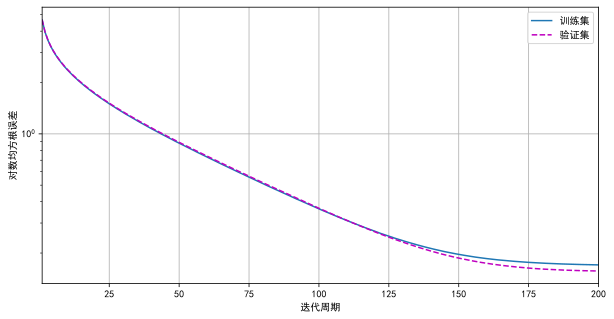

1折，训练log rmse0.170448, 验证log rmse0.156926


(0.03408961296081543, 0.03138514459133148)

In [42]:
k, num_epochs, lr, weight_decay, batch_size = 5, 200, 2, 0, 64
k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

#### 5. 对测试数据进行预测

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='迭代周期',
             ylabel='对数均方根误差', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)